In [51]:
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor as XGBR,XGBClassifier as XGBC,plot_importance
from lightgbm import LGBMRegressor as LGBMR,LGBMClassifier as LGBMC,plot_importance,Booster
from sklearn.ensemble import RandomForestRegressor as RFR,AdaBoostRegressor as ABR
from numpy import sort
from sklearn.linear_model import LogisticRegression as LR
from mlxtend.regressor import StackingCVRegressor as SCVR
from sklearn.svm import SVC
from sklearn.neural_network import MLPRegressor as MLPR

In [52]:
%%time
train_data = pd.read_parquet('/Users/caroline/Downloads/train_data.parquet')
test_data = pd.read_parquet('/Users/caroline/Downloads/test_data.parquet')

CPU times: user 16.2 s, sys: 5.28 s, total: 21.5 s
Wall time: 50.1 s


是否违约取决于用户最近一次帐期后的120天是否支付，所以用户的最后一次报表数据至关重要，它将是我们用于训练的数据主要来源，但是大部分用户有13个月的账期数据，这其中或许也隐藏着信息，把历史数据用于弥补当前账期一些缺失或异常数据带来的误差不失为一种策略。

首先我们取最后一个账期的数据，对全部特征做相关性分析，初步提取出和目标（target）相关系数最大的一些特征（top_features），后续将提取这些特征的历史数据来构建新特征。

In [53]:
data = train_data.groupby('customer_ID').tail(1)
corr_matrix = data.corr()

In [54]:
corr_target = pd.DataFrame(corr_matrix.target)
top_features = corr_target[(abs(corr_target['target'])>=0.5)&(abs(corr_target['target'])!=1)].index.to_list()
top_features

['P_2',
 'B_2',
 'B_3',
 'D_44',
 'D_48',
 'B_7',
 'B_9',
 'D_55',
 'D_61',
 'B_18',
 'B_33']

In [58]:
#缺失值查看
n_df_train = pd.DataFrame(train_data.isnull().sum(axis=0),columns=['n_rate_train'])/len(train_data)
n_df_test = pd.DataFrame(test_data.isnull().sum(axis=0),columns=['n_rate_test'])/len(test_data)
n_df = pd.merge(n_df_train,n_df_test,how='left',left_index=True,right_index=True)

In [59]:
mix_df = n_df.merge(corr_target,how='outer',left_index=True,right_index=True)

In [60]:
#剔除和目标关联度小或缺失严重的特征
drop_features = mix_df[(abs(mix_df['target'])<0.05)|(mix_df['n_rate_train']>0.5)].index.to_list()
#保留B_17,B_42 
drop_features.remove('B_17')
drop_features.remove('B_42')
drop_features.append('S_2')#日期列


In [61]:
drop_features

['B_10',
 'B_12',
 'B_13',
 'B_15',
 'B_26',
 'B_27',
 'B_29',
 'B_36',
 'B_39',
 'B_40',
 'D_102',
 'D_105',
 'D_106',
 'D_108',
 'D_109',
 'D_110',
 'D_111',
 'D_132',
 'D_134',
 'D_135',
 'D_136',
 'D_137',
 'D_138',
 'D_142',
 'D_144',
 'D_42',
 'D_49',
 'D_50',
 'D_53',
 'D_56',
 'D_66',
 'D_69',
 'D_73',
 'D_76',
 'D_82',
 'D_87',
 'D_88',
 'D_93',
 'R_14',
 'R_18',
 'R_23',
 'R_26',
 'R_28',
 'R_9',
 'S_12',
 'S_17',
 'S_18',
 'S_19',
 'S_26',
 'S_5',
 'S_9',
 'S_2']

In [62]:
train_data = train_data.drop(columns=drop_features)
test_data = test_data.drop(columns=drop_features)

In [63]:
top_features.append('customer_ID')
top_features = list(set(top_features))

In [64]:
#把重要特征的均值、中值等作为新特征
extra_features = train_data[top_features].groupby('customer_ID').agg(['first','last','mean','median','std','sum','max','min'])
train_data = train_data.groupby('customer_ID').tail(1)
train_data = pd.merge(train_data,extra_features,how='left',on='customer_ID')

/var/folders/7l/tgtyfd113vbfk2nw_xks1v000000gn/T/ipykernel_22138/3231919275.py:4: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  train_data = pd.merge(train_data,extra_features,how='left',on='customer_ID')


In [65]:
extra_features = test_data[top_features].groupby('customer_ID').agg(['first','last','mean','median','std','sum','max','min'])
test_data = test_data.groupby('customer_ID').tail(1)
test_data = pd.merge(test_data,extra_features,how='left',on='customer_ID')

/var/folders/7l/tgtyfd113vbfk2nw_xks1v000000gn/T/ipykernel_22138/3670765849.py:3: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  test_data = pd.merge(test_data,extra_features,how='left',on='customer_ID')


In [66]:
features_fill_na_mode = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64','D_68']
for feature_mode in features_fill_na_mode:
    mode_value = train_data[feature_mode].value_counts().sort_values(ascending=False).index[0]
    train_data[feature_mode] = train_data[feature_mode].fillna(mode_value)
for feature_mode in features_fill_na_mode:
    mode_value = test_data[feature_mode].value_counts().sort_values(ascending=False).index[0]
    test_data[feature_mode] = test_data[feature_mode].fillna(mode_value)
    

In [67]:
train_data[['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64','D_68']].isnull().sum(axis=0)

B_30     0
B_38     0
D_114    0
D_116    0
D_117    0
D_120    0
D_126    0
D_63     0
D_64     0
D_68     0
dtype: int64

In [68]:
train_data.fillna(train_data.median(),inplace=True)
test_data.fillna(test_data.median(),inplace=True)

/var/folders/7l/tgtyfd113vbfk2nw_xks1v000000gn/T/ipykernel_22138/3665293125.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_data.fillna(train_data.median(),inplace=True)
/var/folders/7l/tgtyfd113vbfk2nw_xks1v000000gn/T/ipykernel_22138/3665293125.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_data.fillna(test_data.median(),inplace=True)


In [69]:
pd.set_option('display.max_row', None)
test_data.isnull().sum(axis=0)

customer_ID       0
P_2               0
D_39              0
B_1               0
B_2               0
R_1               0
S_3               0
D_41              0
B_3               0
D_43              0
D_44              0
B_4               0
D_45              0
B_5               0
R_2               0
D_46              0
D_47              0
D_48              0
B_6               0
B_7               0
B_8               0
D_51              0
B_9               0
R_3               0
D_52              0
P_3               0
B_11              0
S_6               0
D_54              0
R_4               0
S_7               0
S_8               0
D_55              0
R_5               0
D_58              0
B_14              0
D_59              0
D_60              0
D_61              0
S_11              0
D_62              0
D_63              0
D_64              0
D_65              0
B_16              0
B_17              0
B_18              0
B_19              0
B_20              0
D_68              0


In [70]:
test_data.shape

(924621, 226)

In [71]:
train_data.shape

(458913, 227)

In [72]:
Y = train_data.target.values.ravel()
train_data = train_data.drop(columns=['target'])
train_data.shape

(458913, 226)

In [73]:
total = pd.concat([train_data,test_data])
total = total.set_index('customer_ID')
total.shape

(1383534, 225)

In [74]:
categories = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_68']
X = pd.get_dummies(total,columns=categories)

In [75]:
X.columns

Index([     'P_2',     'D_39',      'B_1',      'B_2',      'R_1',      'S_3',
           'D_41',      'B_3',     'D_43',     'D_44',
       ...
        'D_63_XZ',   'D_64_O',   'D_64_R',   'D_64_U', 'D_68_1.0', 'D_68_2.0',
       'D_68_3.0', 'D_68_4.0', 'D_68_5.0', 'D_68_6.0'],
      dtype='object', length=255)

In [76]:
X.shape

(1383534, 255)

In [77]:
X.columns = [str(i).replace('(','').replace(')','').replace(', ','_').replace('\'','') for i in X.columns.to_list()]

In [78]:
X_predict = X.iloc[458913:,:]
X_train_or_test = X.iloc[:458913,:]

In [79]:
X_train_or_test.shape

(458913, 255)

In [80]:
Y.shape

(458913,)

In [81]:
X_train,X_test, y_train, y_test =train_test_split(X_train_or_test,Y,test_size=0.3)

In [83]:
def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

In [84]:
params ={
    'boosting_type':'gbdt',
    'learning_rate':0.05,
    'n_estimators':900,
    'min_split_gain':0,
    'min_child_weight':0.001,
    'max_depth':5,
    'num_leaves':31,
}

In [87]:
folds = KFold(n_splits=5, shuffle=True)
for fold, (train_idx, val_idx) in enumerate(folds.split(X_train_or_test, Y)):
    X_train, y_train = X_train_or_test.iloc[train_idx,:], Y[train_idx]
    X_val, y_val = X_train_or_test.iloc[val_idx,:], Y[val_idx]
    lgbm = LGBMR(**params,random_state=1).fit(X_train, y_train)
    lgbm.booster_.save_model('LGBMmodel_{}.txt'.format(fold))
    val_predict = lgbm.predict(X_val) 
    y_val1 = pd.DataFrame(y_val)
    y_val1.columns = ['target']
    val_predict1 = pd.DataFrame(val_predict)
    val_predict1.columns = ['prediction']
    s = amex_metric(y_val1,val_predict1)
    print("n_fold:{},score:{}".format(fold,s))

n_fold:0,score:0.7805655139002692
n_fold:1,score:0.7820284991524781
n_fold:2,score:0.7768113973877853
n_fold:3,score:0.7799515878068597
n_fold:4,score:0.7829003628749664


In [86]:
lgbm = LGBMR(**params,random_state=1).fit(X_train,y_train)
test_predict = lgbm.predict(X_test) 
y_train_predict = lgbm.predict(X_train)
y_test1 = pd.DataFrame(y_test)
y_test1.columns = ['target']
test_predict1 = pd.DataFrame(test_predict)
test_predict1.columns = ['prediction']
score = amex_metric(y_test1,test_predict1)
score 

0.7803468271096909

In [53]:
for i in range(5,25,5):
    for j in range(100,1500,100):
        lgbm = LGBMR(learning_rate=i/100,n_estimators=j,random_state=1,).fit(X_train,y_train)
        test_predict = lgbm.predict(X_test) 
        y_train_predict = lgbm.predict(X_train)
        y_test1 = pd.DataFrame(y_test)
        y_test1.columns = ['target']
        test_predict1 = pd.DataFrame(test_predict)
        test_predict1.columns = ['prediction']
        score = amex_metric(y_test1,test_predict1)
        print("i:{},j:{},score:{}".format(i,j,score))


i:5,j:100,score:0.7694091437921491
i:5,j:200,score:0.7771272018492108
i:5,j:300,score:0.7782785756001841
i:5,j:400,score:0.7794050108505788
i:5,j:500,score:0.7796143287571342
i:5,j:600,score:0.7794641475046262
i:5,j:700,score:0.7801042631409318
i:5,j:800,score:0.7801961274903078
i:5,j:900,score:0.780365176219121
i:10,j:100,score:0.7758545946278159
i:10,j:200,score:0.7766311573260153
i:10,j:300,score:0.7770152373417021
i:10,j:400,score:0.7766558400167396
i:10,j:500,score:0.7765391860451791
i:10,j:600,score:0.7758375611759212
i:10,j:700,score:0.7754795203139124
i:10,j:800,score:0.7753927281485813
i:10,j:900,score:0.774736636903081
i:15,j:100,score:0.7757086283126186
i:15,j:200,score:0.7752713880621701
i:15,j:300,score:0.7741363186217216
i:15,j:400,score:0.7737342370209888
i:15,j:500,score:0.7730426525154546
i:15,j:600,score:0.7718286419974588
i:15,j:700,score:0.7709401160254836
i:15,j:800,score:0.770207848400712
i:15,j:900,score:0.7691370763867331


In [56]:
for i in range(2,32,1):
    for j in range(1):
        lgbm = LGBMR(learning_rate=0.05,n_estimators=900,max_depth=5,num_leaves=i,random_state=1,).fit(X_train,y_train)#0.7754706768660901
        test_predict = lgbm.predict(X_test) 
        y_train_predict = lgbm.predict(X_train)
        y_test1 = pd.DataFrame(y_test)
        y_test1.columns = ['target']
        test_predict1 = pd.DataFrame(test_predict)
        test_predict1.columns = ['prediction']
        score = amex_metric(y_test1,test_predict1)
        print("i:{},j:{},score:{}".format(i,j,score))


i:2,j:0,score:0.753476591987293
i:3,j:0,score:0.7672161869723174
i:4,j:0,score:0.7716975169725918
i:5,j:0,score:0.7738666386133443
i:6,j:0,score:0.7760349990825586
i:7,j:0,score:0.7775382386851677
i:8,j:0,score:0.7780849990554091
i:9,j:0,score:0.778851524958281
i:10,j:0,score:0.7772517692592368
i:11,j:0,score:0.7790456296781914
i:12,j:0,score:0.7790041324756087
i:13,j:0,score:0.7793094752848573
i:14,j:0,score:0.7796851012123621
i:15,j:0,score:0.7795566222874099
i:16,j:0,score:0.7801256149825556
i:17,j:0,score:0.7802101690602387
i:18,j:0,score:0.7798720100240613
i:19,j:0,score:0.779478057380554
i:20,j:0,score:0.779672124862352
i:21,j:0,score:0.7796698712836733
i:22,j:0,score:0.7803733271974241
i:23,j:0,score:0.7795642971571879
i:24,j:0,score:0.7807396583666696
i:25,j:0,score:0.7796473958629344
i:26,j:0,score:0.7796675107562564
i:27,j:0,score:0.7796634394528625
i:28,j:0,score:0.7787157081470407
i:29,j:0,score:0.7791976166424368
i:30,j:0,score:0.7794397730018843
i:31,j:0,score:0.780351779

In [ ]:
xgbr =  XGBR(n_estimators=70,max_depth=5,random_state=123).fit(X_train,y_train)
test_predict = xgbr.predict(X_test) 
y_train_predict = xgbr.predict(X_train)
y_test1 = pd.DataFrame(y_test)
y_test1.columns = ['target']
test_predict1 = pd.DataFrame(test_predict)
test_predict1.columns = ['prediction']
score = amex_metric(y_test1,test_predict1)
score

/Users/caroline/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


0.7680404821327709

In [91]:
nn= MLPR(random_state=123).fit(X_train,y_train)
test_predict = nn.predict(X_test) 
y_train_predict = nn.predict(X_train)
y_test1 = pd.DataFrame(y_test)
y_test1.columns = ['target']
test_predict1 = pd.DataFrame(test_predict)
test_predict1.columns = ['prediction']
score = amex_metric(y_test1,test_predict1)
score

0.7721908060178067

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

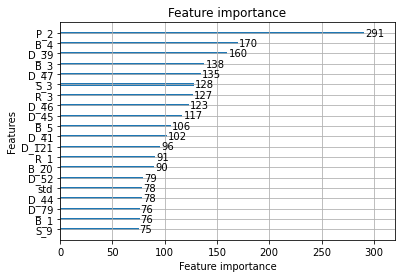

In [ ]:
plot_importance(lgbm,max_num_features=20)

In [88]:
# lgbm = LGBMR(n_estimators=240,learning_rate=0.015,random_state=123)
# xgbr =  XGBR(n_estimators=70,max_depth=5,random_state=123)
# nn= MLPR()
# scvr =  SCVR(regressors=[lgbm,xgbr], meta_regressor=nn,random_state=123).fit(X_train,y_train)
# test_predict = scvr.predict(X_test)
# y_train_predict = scvr.predict(X_train)
# y_test1 = pd.DataFrame(y_test)
# y_test1.columns = ['target']
# test_predict1 = pd.DataFrame(test_predict)
# test_predict1.columns = ['prediction']
# score = amex_metric(y_test1,test_predict1)
# score

In [89]:
for i in range(5):
    bst = Booster(model_file=('LGBMmodel_{}.txt').format(i))
    predictions = bst.predict(X_predict)
    submission = pd.DataFrame({"customer_ID":X_predict.index,"prediction":predictions})
    submission.to_csv('submission_{}.csv'.format(i), index=False)

In [48]:
prediction = lgbm.predict(X_predict)

In [49]:
prediction.mean()

0.0703961920242333

In [43]:
submission = pd.DataFrame({"customer_ID":X_predict.index,"prediction":prediction})

<AxesSubplot:>

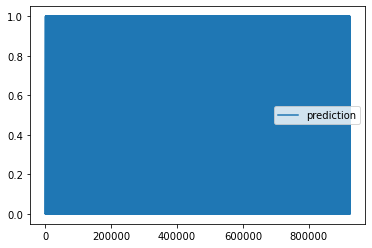

In [44]:
submission.plot()

In [45]:
submission.head()

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.0
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.0
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.0
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.0
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.0


In [46]:
submission.to_csv('submission.csv', index=False)